Mixture of Gaussians model posterior distribution estimation based on:

(1) Our MH test

(2) Korattikara's paper: Cutting the MH Budget

(3) Bardenet's paper: On Markov chain Monte Carlo methods for tall data

(4) Bardenet's paper: Towards scaling up Markov chain Monte Carlo: an adaptive subsampling approach

The mixture model is based on Section 5.1 of "Bayesian Learning via Stochastic Gradient Langevin Dynamics" (2011). 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t
import sys
import scipy.io
from bisect import bisect
import copy

In [7]:
# Our MH Test
class our_mh:
    def __init__(self, x, ecdfmat, sd_vect):
        self.X = x  # data
        self.N = x.shape[0]
        self.ecdfmat = ecdfmat
        self.sd_vect = sd_vect
    
    def randomWalkProposer(self, theta, eps_sq):
        # random walk proposer to get the next parameter set
        # input: theta: 1-D Array like, of length 2
        #        eps_sq: 2-D Array like, the covariance matrix
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def log_f(self, theta, X, N, T):
        """
        The function 'f' is the posterior:
    
        f(theta) \propto p(\theta) * \prod_{i=1}^N p(x_i | \theta)
        """
        scale_and_temp = N / float(len(X) * T)
    
        inverse_covariance = np.array([[0.1,0],[0,1]])
        prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
        prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
        X_all = X.reshape((len(X),1))
        ll_constant = (1.0 / (4*np.sqrt(np.pi)))
        L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + \
                           np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
        log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
        assert (N / float(len(X))) >= 1
        assert not np.isnan(prior + log_likelihood)
        return (prior + log_likelihood)[0,0]
    
    def get_delta(self, theta_c, theta_p, X, N, T):
        loss_old = self.log_f(theta_c, X, N, T)
        loss_new = self.log_f(theta_p, X, N, T)
        assert not np.isnan(loss_new - loss_old)
        return loss_new - loss_old

    def estimateVar_from_one_batch (self, theta_c, theta_p, X, N, T):
        n = len(X)
        # notice here, we need to set up the N and T to be 1, and rescale them later 
        tmp_delta = [self.get_delta(theta_c, theta_p, np.asarray([x]), 1, 1) for x in X]
        varRes = np.var(np.asarray(tmp_delta))
        varRes = varRes * (1.0*N/n/T)**2.0 *n
        assert not np.isnan(varRes)
        return varRes
    
    def update_delta_and_sd_one_more_minibatch(self, theta_c, theta_p, X, n, N, T, old_delta, old_sd_delta):
        newDelta = self.get_delta(theta_c, theta_p, X, N, T)
        updated_delta = (old_delta * n + newDelta)*1.0 / (n+1)
        newVar = self.estimateVar_from_one_batch(theta_c, theta_p, X, N, T)
        m = len(X)
        updated_sd = ((old_sd_delta**2.0 *(n*m)**2 + newVar* m**2) / (m*(n+1))**2)**0.5
        return (updated_delta, updated_sd)
    
    def get_rand_xcorr(self, ecdf, sdvect, estimated_sd):
        index = bisect(sdvect, estimated_sd) + 1
        x = ecdf[0,:]
        f = ecdf[index, :]
        u = np.random.random()
        return x[bisect(f, u)]
    
    def posterior_estimation(self, num_passes, \
                             rw_eps, temperature, \
                             mb_size, theta, \
                             num_samples_delta, \
                             mavg):
        our_MH_accept_1 = []
        our_MH_reject_1 = []
        our_sds_1 = []
        our_deltas_1 = []
        our_xcorrs_1 = []
        data_consume = []
        all_3 = theta
        sd = 0
        
        for T in range(1, num_passes):  
            #if (T % int(num_passes/4) == 0):
            #    print("T={}".format(T))
            print T
            theta_new = self.randomWalkProposer(theta, rw_eps)
            X_mb_real = self.X[np.random.choice(self.N, mb_size, replace=False)]
            delta_real = self.get_delta(theta, theta_new, X_mb_real, self.N, temperature)
            
            X_mini_batch = X[np.random.choice(self.N, mb_size, replace=False)]
            this_est_std = self.estimateVar_from_one_batch(theta, theta_new, X_mini_batch, self.N, temperature)**0.5
            projected_mavg = this_est_std
            num_mini_batch = 1
            while (projected_mavg >= 1.188):
                # we need to consume more data here
                X_new_mini_batch = X[np.random.choice(self.N, mb_size, replace=False)]
                updatedval = self.update_delta_and_sd_one_more_minibatch(theta, theta_new, X_new_mini_batch,\
                                                                         num_mini_batch, self.N, temperature, delta_real,\
                                                                        projected_mavg)
                projected_mavg = updatedval[1]
                delta_real = updatedval[0]
                num_mini_batch += 1
        
            data_consume.append(num_mini_batch)
            # Now we update the moving average and take advantage of pre-computed data.
            sd = projected_mavg
            X_corr = self.get_rand_xcorr(self.ecdfmat, self.sd_vect, sd)
    
      
            # Gather data for diagnostics.
            our_deltas_1.append(delta_real)
            our_sds_1.append(sd)
            our_xcorrs_1.append(X_corr)
    
            # Now *finally* do the test!
            if (X_corr + delta_real > 0):
                theta = theta_new
                our_MH_accept_1.append(T)
            else:
                our_MH_reject_1.append(T)
            all_3 = np.concatenate((all_3,theta), axis=1)
        return (all_3, data_consume)

In [8]:
# Generate data
N = 10000 # number of points
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
X = np.zeros(N)
i = 0
while i < N :
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        i = i + 1
    elif (u>0.5):
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))
        i = i + 1
        
# Load XcorrCurves.mat
mat = scipy.io.loadmat('../generateXcorr/XcorrCurves.mat')
ecdfmat = mat['res']
sd_vect = mat['sdval']

In [ ]:
# *********** Run Our MH Test **********
num_passes = 10000
rw_eps = 0.03 * np.eye(2)
temperature = 110
mb_size = 200
theta = np.array([[0.5],[0]])
num_samples_delta = 5
mavg = 0.7
mhtest = our_mh(X, ecdfmat, sd_vect)

# iterate using different temperature and mb_size

for temperature in range(2,100,20):
    for mb_size in range(100,500,100):
        print 'Temperature and minibatch size are:' 
        print temperature, mb_size
        (all3, data_consume) = mhtest.posterior_estimation(num_passes, \
                             rw_eps, temperature, \
                             mb_size, theta, \
                             num_samples_delta, \
                             mavg)
        # plot result
        fig, axarr = plt.subplots(1,2,figsize=(15,5))
        axarr[0].set_title("Our Method with Temperature = " + str(temperature) + \
                           " and minibatch size = " + str(mb_size), size="x-large")
        axarr[0].scatter(all3[0], all3[1])
        axarr[0].set_xlim([-1.5,2.5])
        axarr[0].set_ylim([-3,3])
        dataconsume = np.asarray(data_consume)
        axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
        axarr[1].hist(dataconsume*200, bins=10, facecolor ='green')
        axarr[1].set_xlabel("Data Instances", size="x-large")
        axarr[1].set_ylabel("Counts", size="x-large")
        plt.tight_layout()
        plt.show()

Temperature and minibatch size are:
2 100
1
2
3
4


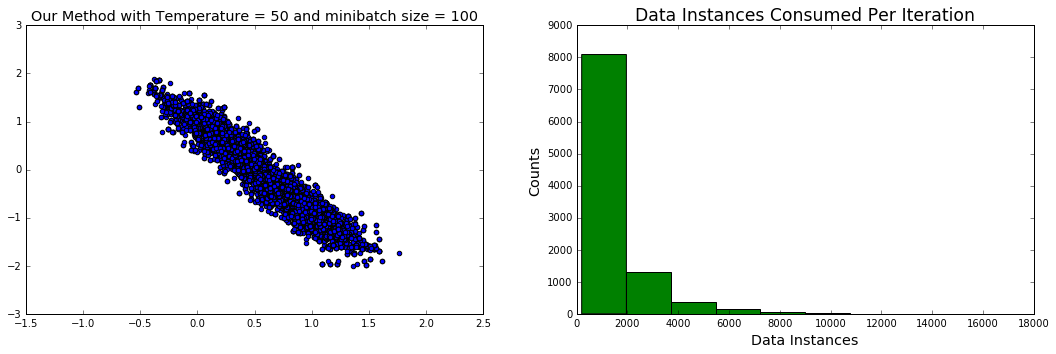

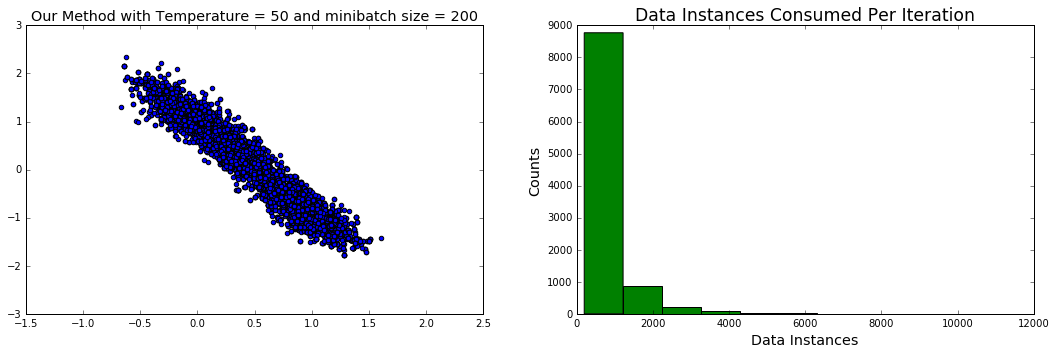

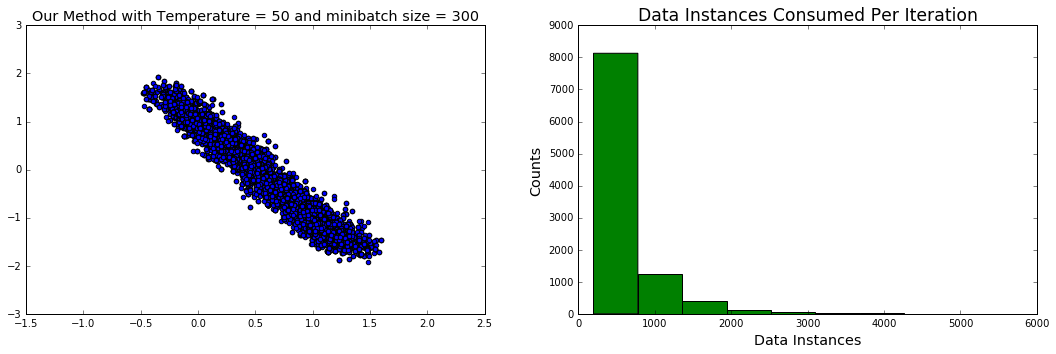

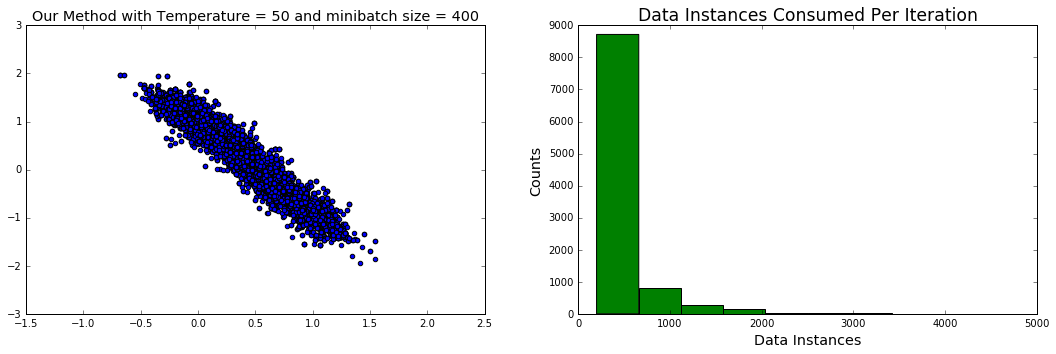

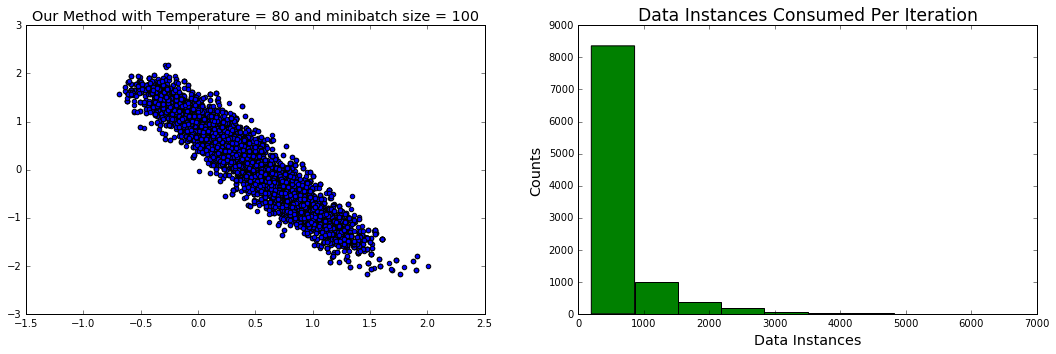

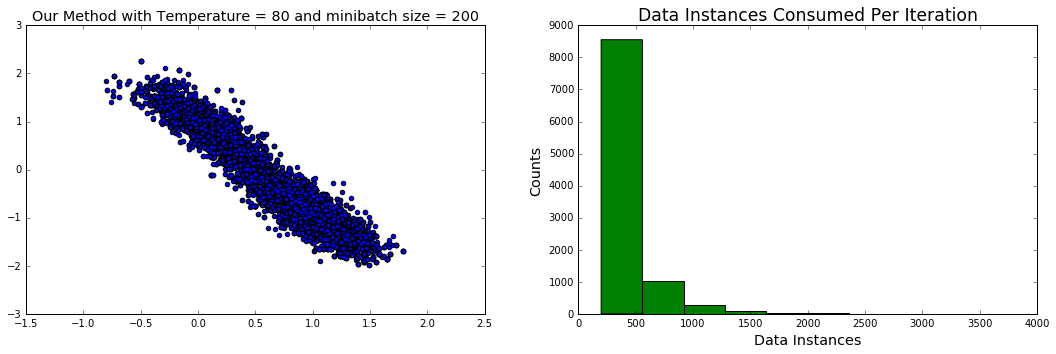

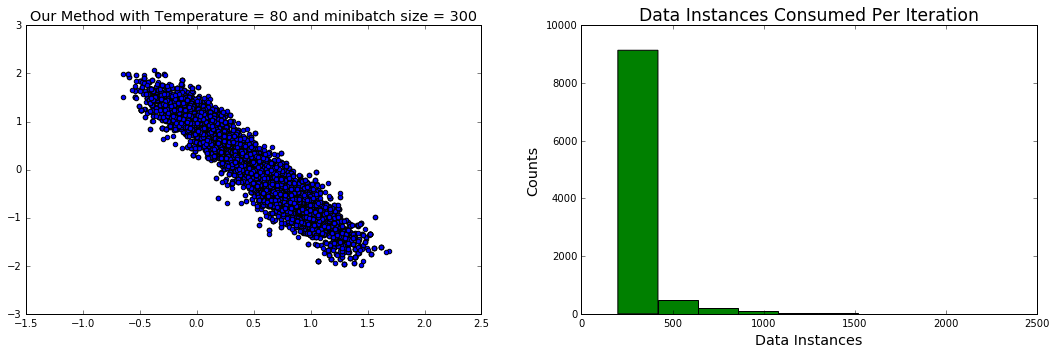

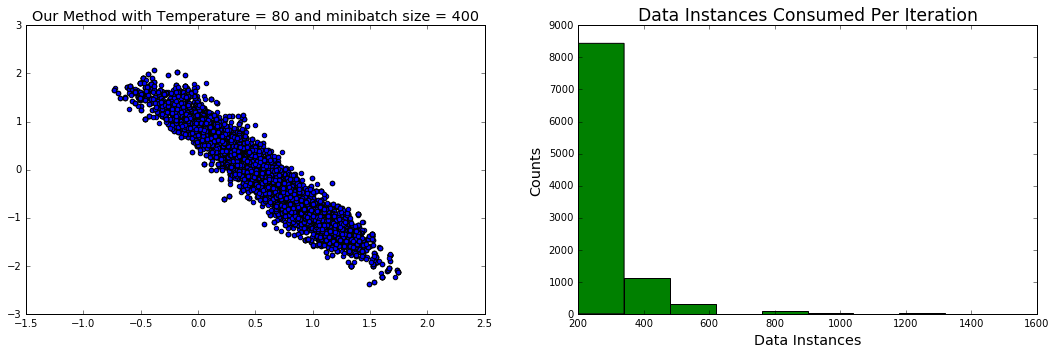

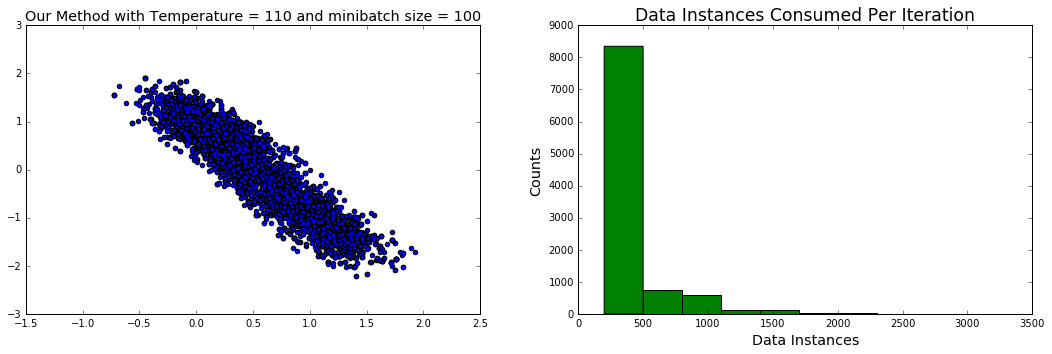

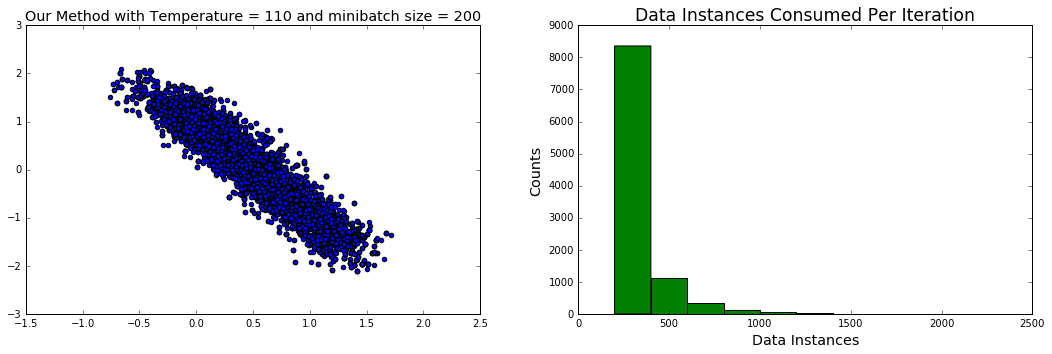

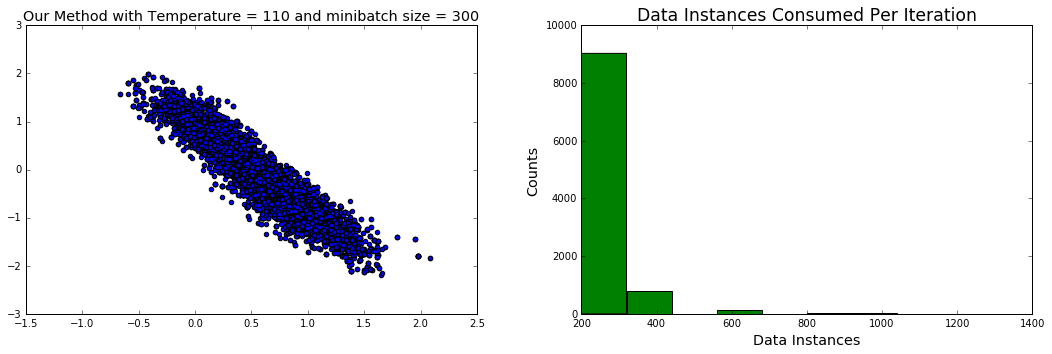

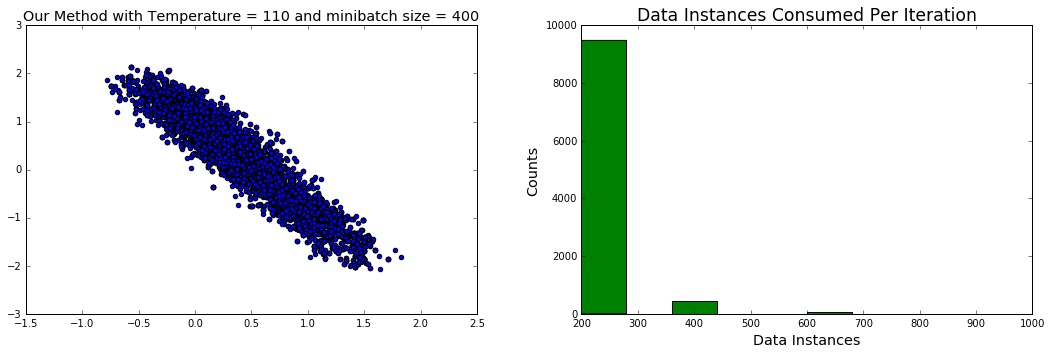

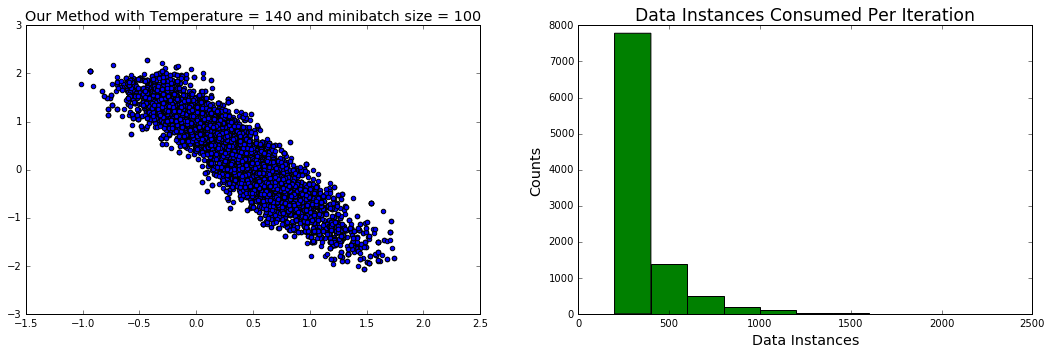

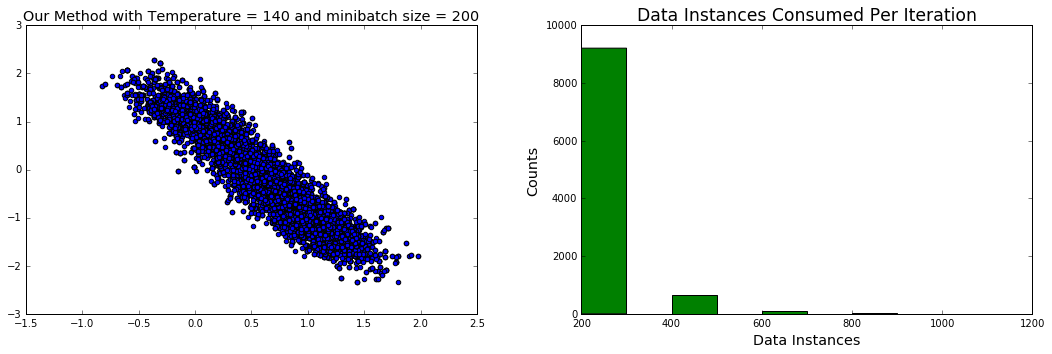

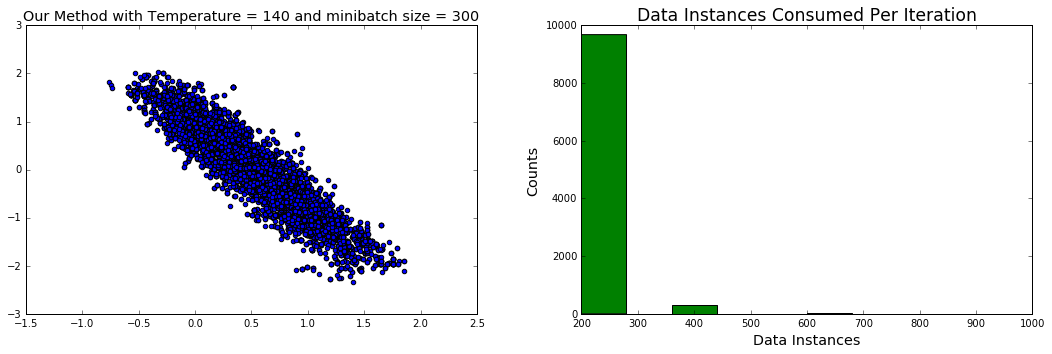

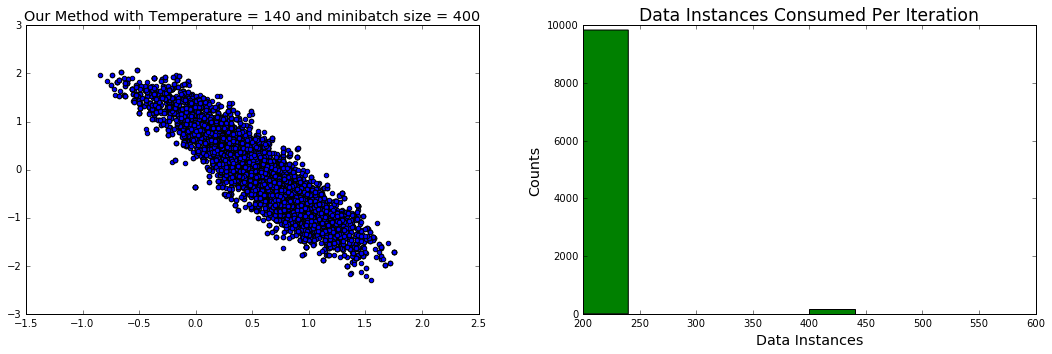

In [5]:
# show results of our method
for temp in range(50,150,30):
    for mb_size in range(100,500,100):
        posterior_filename = "results/all3_T" + str(temp) + "mb" + str(mb_size) + ".txt"
        data_consume_filename = "results/dataconsume_T" + str(temp) +  "mb" + str(mb_size) + ".txt"
        posterior = np.loadtxt(posterior_filename)
        data_consume = np.loadtxt(data_consume_filename)
        
        # plot results
        fig, axarr = plt.subplots(1,2,figsize=(15,5))
        title = "Our Method with Temperature = " + str(temp) + " and minibatch size = " + str(mb_size)
        axarr[0].set_title(title, size="x-large")
        axarr[0].scatter(posterior[0], posterior[1])
        axarr[0].set_xlim([-1.5,2.5])
        axarr[0].set_ylim([-3,3])
        dataconsume = np.asarray(data_consume)
        axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
        axarr[1].hist(data_consume*200, bins=10, facecolor ='green')
        axarr[1].set_xlabel("Data Instances", size="x-large")
        axarr[1].set_ylabel("Counts", size="x-large")
        plt.tight_layout()
        plt.show()

In [ ]:
# Cutting the MH Budget Method: Korattikara's paper
class cut_mh:
    def __init__(self,x):
        self.X = x
        self.N = x.shape[0]
        
    def randomWalkProposer(self, theta, eps_sq):
        # random walk proposer to get the next parameter set
        # input: theta: 1-D Array like, of length 2
        #        eps_sq: 2-D Array like, the covariance matrix
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def log_f_prior(self, theta, theta_var):
        '''
        function to calculate the prior term : log(p(\theta))
        '''
        Sigma = np.array([[theta_var[0],0],[0,theta_var[1]]])
        res_first_part = -1.0 * np.log( 2 * np.pi * np.sqrt(np.linalg.det(Sigma)) ) 
        res_second_part = -0.5 * (theta.T).dot(np.linalg.inv(Sigma)).dot(theta)
        return res_first_part + res_second_part
    
    def compute_mu0(self, theta_c, theta_p, theta_var, N):
        prior_old = self.log_f_prior(theta_c, theta_var)
        prior_new = self.log_f_prior(theta_p, theta_var)
        log_u = np.log(np.random.random())
        
        assert not np.isnan(prior_old)
        assert not np.isnan(prior_new)
        assert not np.isnan(log_u)
        
        res = 1.0 /N * ( log_u + prior_old - prior_new )
        assert not np.isnan(res)
        
        return res
    
    def mh_test(self, theta_c, theta_p, mb_size, X, N, mu_0, eps_tolerance, T, var_X):
        '''
        performing MH test: theta_c: current paramter value
                            theta_p: potential new parameter value
                            mb_size: minibatch size
                            X      : total data set
                            N      : size of total data set
                            T      : temperature
                            var_X  : the variance of X
        '''
        accept = False
        done = False
        n = 0
        
        index = np.random.permutation(N)
        X = X[index]
        
        while not done:
            size = np.min([mb_size, N-n])  # minibatch size
            n = n + size
            X_mini = (X[:n]).reshape((n,1))
            
            # compute l_bar, l_bar_square
            numerator = np.exp(-0.5/var_X * (X_mini - theta_p[0])**2 ) \
                      + np.exp(-0.5/var_X * (X_mini- (theta_p[0] + theta_p[1])) **2 )
            denominator = np.exp(-0.5/var_X * (X_mini - theta_c[0])**2 )\
                      + np.exp(-0.5/var_X * (X_mini - (theta_c[0] + theta_c[1])) ** 2)
            log_terms = (1.0/T) * np.log(numerator/denominator)
            l_bar = (1.0/n) * np.sum(log_terms)
            l_bar_square = (1.0/n) * np.sum(log_terms**2)
            
            assert not np.isnan(np.sum(numerator))
            assert not np.isnan(np.sum(denominator))
            assert not np.isnan(l_bar)
            assert not np.isnan(l_bar_square)
            
            if (n == N):
                delta = 0
            else:
                s_l = np.sqrt( (l_bar_square - (l_bar**2)) * (float(n)/(n-1)) )
                s = (s_l/ np.sqrt(n)) * np.sqrt( 1 - (float(n-1)/(N-1))  )
                test_statistic = np.abs( (l_bar - mu_0)/s )
                delta = 1 - t.cdf(test_statistic, n-1)
                assert not np.isnan(delta)
                assert not np.isnan(s)
                
            if (delta < eps_tolerance) :
                if ( l_bar > mu_0 ):
                    accept = True
                done = True
        return (accept, n)
            
    def posterior_estimate(self, num_pass, rw_eps, temperature, mb_size, theta_start, tolerance, var_X, theta_var):
        theta = theta_start
        theta_list = theta_start
        X = self.X
        cutting_MH_sizes_accept = []
        cutting_MH_sizes_reject = []
        cutting_MH_accept = []
        cutting_MH_reject = []
        data_consume = []
        for T in range(1, num_pass):
            theta_new = self.randomWalkProposer(theta, rw_eps)
            mu_0 = self.compute_mu0(theta, theta_new, theta_var, self.N)
            (accept, this_mb_size) = self.mh_test(theta, theta_new, mb_size, X, self.N, mu_0, tolerance, temperature, var_X)
            
            assert this_mb_size >= mb_size
            
            if accept:
                theta = theta_new
                cutting_MH_sizes_accept.append(this_mb_size)
                cutting_MH_accept.append(T)
            else:
                cutting_MH_sizes_reject.append(this_mb_size)
                cutting_MH_reject.append(T)
            theta_list = np.concatenate( (theta_list, theta), axis=1 )
            data_consume.append(this_mb_size)
        return (theta_list, data_consume) 

Temperature and minibatch size are:
1 100


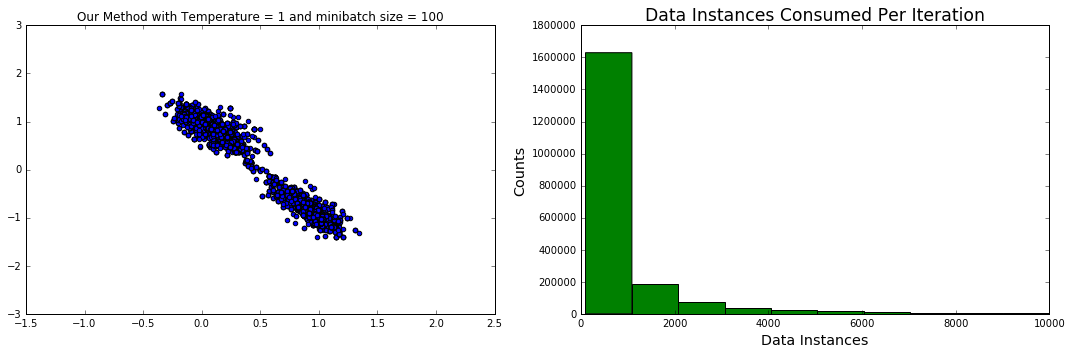

Temperature and minibatch size are:
1 200


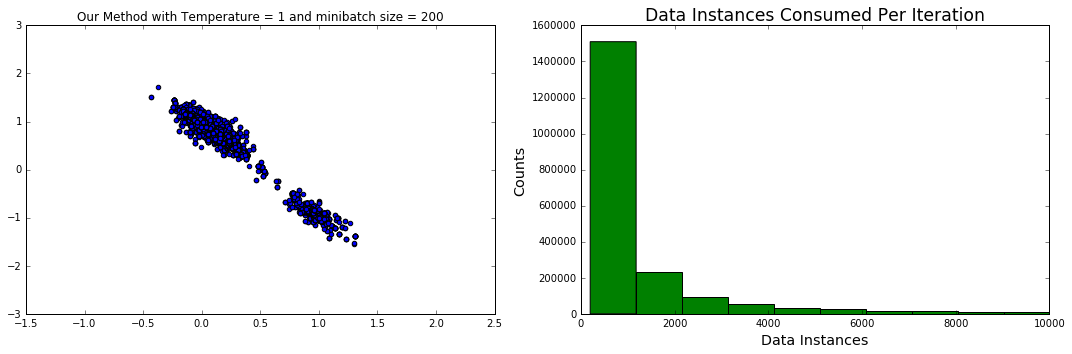

Temperature and minibatch size are:
1 300


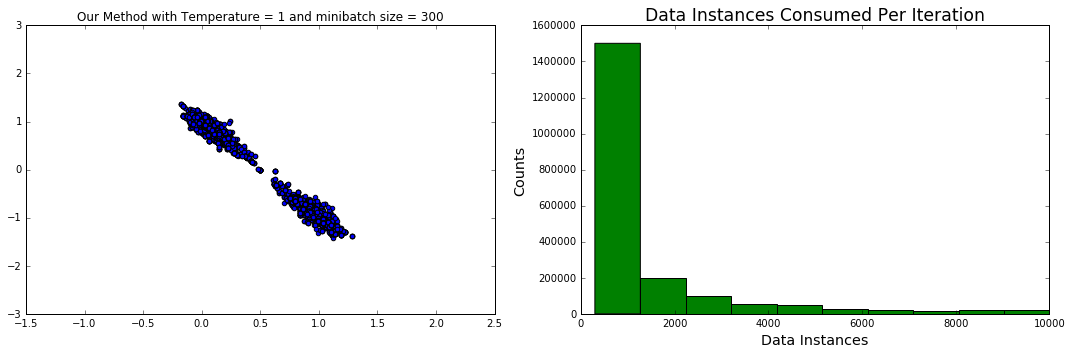

Temperature and minibatch size are:
1 400


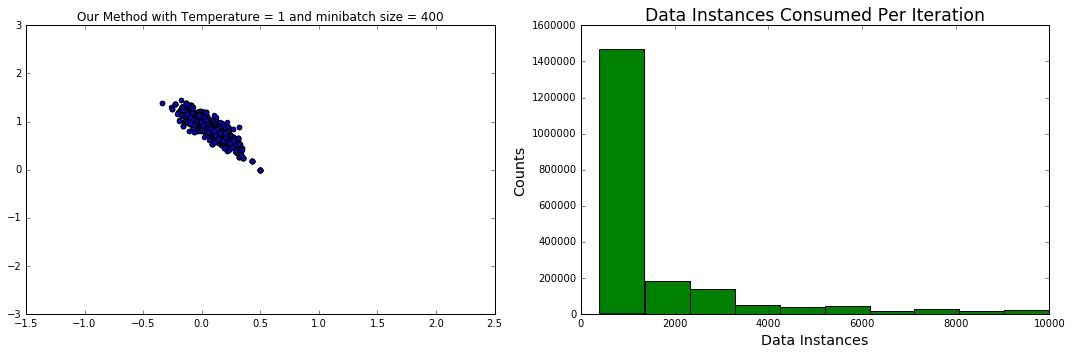

Temperature and minibatch size are:
21 100


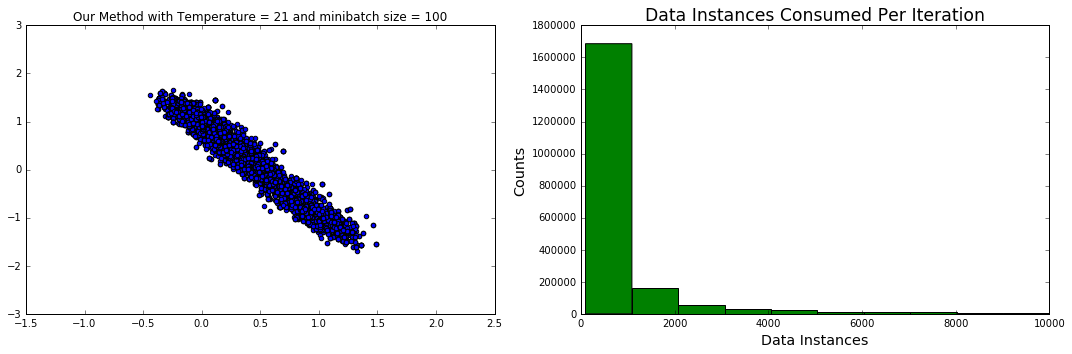

Temperature and minibatch size are:
21 200


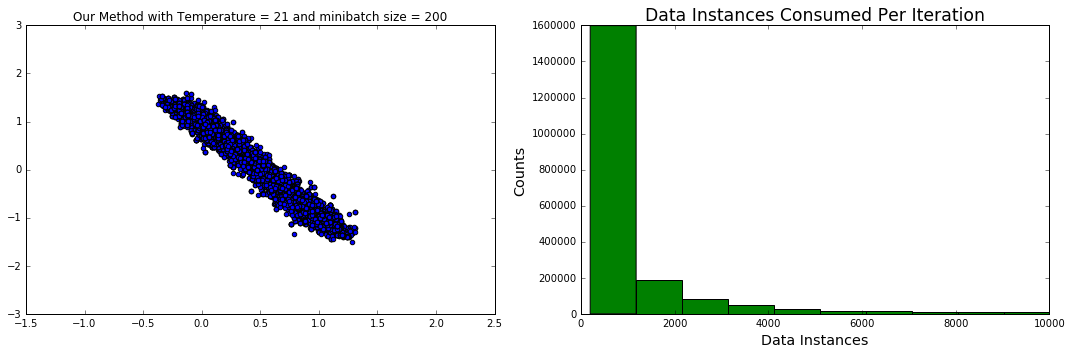

Temperature and minibatch size are:
21 300


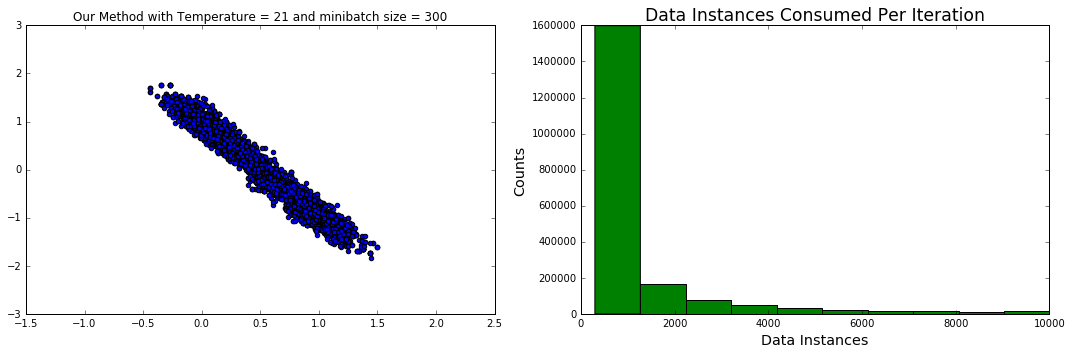

Temperature and minibatch size are:
21 400


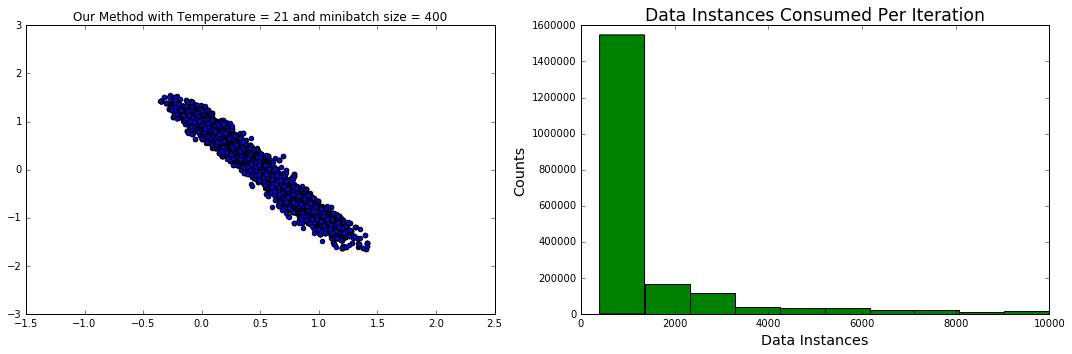

Temperature and minibatch size are:
41 100


In [ ]:
# run the adaptive sampling method
num_passes = 10000
rw_eps = 0.03 * np.eye(2)
temperature = 110
mb_size = 200
theta = np.array([[0.5],[0]])
mhtest = cut_mh(X)
tolerance = 0.1
var_X = 2
theta_var = np.array([10,1])

for temperature in range(1,100,20):
    for mb_size in range(100,500,100):
        print 'Temperature and minibatch size are:' 
        print temperature, mb_size
        (all3, data_consume) = mhtest.posterior_estimate(num_passes,rw_eps,temperature,mb_size,theta, tolerance, \
                             var_X, theta_var)
        # plot result
        fig, axarr = plt.subplots(1,2,figsize=(15,5))
        axarr[0].set_title("Our Method with Temperature = " + str(temperature) + \
                           " and minibatch size = " + str(mb_size) )
        axarr[0].scatter(all3[0], all3[1])
        axarr[0].set_xlim([-1.5,2.5])
        axarr[0].set_ylim([-3,3])
        dataconsume = np.asarray(data_consume)
        axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
        axarr[1].hist(data_consume*200, bins=10, facecolor ='green')
        axarr[1].set_xlabel("Data Instances", size="x-large")
        axarr[1].set_ylabel("Counts", size="x-large")
        plt.tight_layout()
        plt.show()

In [28]:
# Bardenet's 14' Paper
class adaptive_mh14:
    def __init__(self,x):
        self.X = x
        self.N = x.shape[0]
    
    def randomWalkProposer(self, theta, eps_sq):
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def log_p(self, theta, theta_var):
        '''
        log prior : log(p(\theta))
        '''
        Sigma = np.array([[theta_var[0],0],[0,theta_var[1]]])
        res_first_part = -1.0 * np.log( 2.0 * np.pi * np.sqrt(np.linalg.det(Sigma)) ) 
        res_second_part = -0.5 * (theta.T).dot(np.linalg.inv(Sigma)).dot(theta)
        return res_first_part + res_second_part
        
    
    def log_ll(self, X, theta, var_X):
        '''
        function to calculate log likelihood term: \sum_{i=1}^b{log(p(x_i|\theta))}
        input: var_X : variance of x : var_X = 2
        '''
        X_all = X.reshape((len(X),1))
        ll_constant = 1.0 / (np.sqrt(2.0 * np.pi * var_X) * 2.0 )
        L = ll_constant * ( np.exp(-0.5/var_X * (X_all-theta[0])**2) + \
                           np.exp(-0.5/var_X *(X_all-(theta[0]+theta[1]))**2) )
        log_likelihood = np.sum(np.log(L))
        return log_likelihood
    
    def calculate_c_theta(self, theta_c, theta_p, var_X):
        '''
        function to calculate C_{\theta, \theta'} according to the paper
        '''
        res = 0
        for i in range(self.N):
            x = np.array([[self.X[i]]])
            temp = np.abs( self.log_ll(x, theta_c, var_X) - self.log_ll(x, theta_p, var_X) )
            if temp > res :
                res = temp
        return res
  
    def function_phi(self, theta_c, theta_p, theta_var):
        '''
        function_phi = 1/n * log[ u * p(\theta) / p(\theta')]
        since we use a random walk proposer, so q(\theta'|\theta) = q(\theta|\theta')
        
        input: theta_c: current theta value
               theta_p: proposed theta value
               theta_var: variance of theta : [10,1]
        '''
        u = np.random.random()
        phi = 1.0/self.N * ( np.log(u) + self.log_p(theta_c, theta_var) - self.log_p(theta_p, theta_var) )
        return phi
    
    def posterior_estimation(self, num_pass, theta_start, eps_sq, theta_var, var_X, p, delta, gamma, temperature):
        '''
        function to perform posteriro estimation
        input: b : minibatch size
               p : a value to calculate delta_t
               temperature
        '''
        theta = theta_start
        theta_list = copy.deepcopy(theta_start)
        batch_size = []
        for k in range(num_pass):
            data = self.X
            N = data.shape[0]
            theta_new = self.randomWalkProposer(theta, eps_sq)
            phi = self.function_phi(theta, theta_new, theta_var)
            t = 0
            t_look = 0.0
            A_star = 0.0
            b = 1   # initialize batchsize to 1
            done = False
            while done == False:
                sample_index = np.random.choice(data.shape[0], b-t, replace=False)
                X_mini = data[sample_index]
                data = np.delete(data, sample_index)
                A_star = 1.0 / b * ( t*A_star + 1.0/temperature * self.log_ll(X_mini,theta_new,var_X)*1.0\
                                    - 1.0/temperature * self.log_ll(X_mini, theta, var_X)*1.0 )
                t = b
                
                CTT =  self.calculate_c_theta(theta, theta_new, var_X)
                ft = (len(X_mini) -1.0)/self.N
                delta_t_look = (p-1.0)/(np.power(p, np.power(t_look,p) ) *1.0 ) * delta
                
                c = 2 * CTT * np.sqrt( ((1.0- ft) * np.log(2.0/delta_t_look)) / (2*t) )
                
                t_look = t_look + 1.0
                
                b = min(self.N, gamma * t)
                
                if np.abs(A_star - phi) >= c or b >= self.N :
                    done = True
            if A_star > phi :
                theta = theta_new
            else:
                theta = theta
            theta_list = np.concatenate((theta_list, theta), axis=1)
            batch_size.append(b)
        return (theta_list, batch_size)                

In [ ]:
# ************** Run Bardenet 14' Paper *************
num_passes = 1000
rw_eps = 0.03 * np.eye(2)
theta_start = np.array([[0.5],[0]])
theta_var = np.array([10,1])
var_X = 2
p = 2 # according to the paper p > 1, delta = 0.01, gamma= 2
delta = 0.01
gamma = 2 
bard_test = adaptive_mh14(X)

# do estimation
(posterior, data_consume) = \
bard_test.posterior_estimation(num_passes, theta_start, rw_eps, theta_var, var_X, p, delta, gamma)

fig, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].set_title("Our Method", size="x-large")
axarr[0].scatter(posterior[0], posterior[1])
axarr[0].set_xlim([-1.5,2.5])
axarr[0].set_ylim([-3,3])
dataconsume = np.asarray(data_consume)
axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
axarr[1].hist(data_consume*200, bins=10, facecolor ='green')
axarr[1].set_xlabel("Data Instances", size="x-large")
axarr[1].set_ylabel("Counts", size="x-large")
plt.tight_layout()
plt.show()